In [1]:
import nibabel as nib
import numpy as np
import os
import cv2
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, callbacks, metrics, Input, Model, regularizers
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, auc, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight

In [2]:
def calculate_label(image, threshold=0.04):
    """
    Determina o label da subimagem com base no percentual de fundo não-preto.
    :param subimage: Array da subimagem.
    :param threshold: Percentual mínimo de fundo não-preto para considerar como label 1.
    :return: String indicando o label.
    """
    # Total de pixels na subimagem
    total_pixels = image.size
    # Número de pixels não-preto
    non_zero_pixels = np.count_nonzero(image)
    # Proporção de pixels não-preto
    non_black_ratio = non_zero_pixels / total_pixels if total_pixels > 0 else 0
    
    # Verifica se há lesão e se o fundo não-preto é maior que o limiar
    if np.any(image == 1) and non_black_ratio >= threshold:
        return 1
    else:
        return 0

def load_patient_data(folder, patient_id):
    """
    Carrega os dados de um único paciente (imagens, máscaras e labels) de um diretório.

    Args:
        folder (str): Caminho da pasta contendo os dados dos pacientes.
        patient_id (str): ID do paciente a ser carregado.

    Returns:
        dict: Dados do paciente, incluindo imagens, máscaras e labels para os lados esquerdo e direito.
              Retorna None se o paciente não for encontrado.
    """
    patient_path = os.path.join(folder, patient_id)
    if not os.path.exists(patient_path):
        print(f"Paciente {patient_id} não encontrado na pasta {folder}.")
        return None

    # Inicializa estruturas para armazenar os dados do paciente
    patient_data = {
        "images_left": [],
        "images_right": [],
        "mask_left": [],
        "mask_right": [],
        "labels_left": [],
        "labels_right": [],
    }

    areas_image = ["left", "right"]
    areas_mask = ["lesion_left", "lesion_right"]
    path_left = os.path.join(patient_path, areas_image[0])
    path_right = os.path.join(patient_path, areas_image[1])
    lesion_path_left = os.path.join(patient_path, areas_mask[0])
    lesion_path_right = os.path.join(patient_path, areas_mask[1])

    # Verifica se os diretórios existem
    if not os.path.exists(path_left) or not os.path.exists(path_right) or \
       not os.path.exists(lesion_path_left) or not os.path.exists(lesion_path_right):
        print(f"Estrutura de diretórios inválida para o paciente {patient_id}.")
        return None

    # Carrega as imagens e máscaras do lado esquerdo e direito
    for patch_id_left, mask_id_left, patch_id_right, mask_id_right in zip(
        os.listdir(path_left), os.listdir(lesion_path_left),
        os.listdir(path_right), os.listdir(lesion_path_right)
    ):
        img_path_left = os.path.join(path_left, patch_id_left)
        mask_path_left = os.path.join(lesion_path_left, mask_id_left)
        img_path_right = os.path.join(path_right, patch_id_right)
        mask_path_right = os.path.join(lesion_path_right, mask_id_right)

        for img_left, msk_left, img_right, msk_right in zip(
            os.listdir(img_path_left), os.listdir(mask_path_left),
            os.listdir(img_path_right), os.listdir(mask_path_right)
        ):
            # Carrega os dados do lado esquerdo
            data_left = nib.load(os.path.join(img_path_left, img_left)).get_fdata()
            data_msk_left = nib.load(os.path.join(mask_path_left, msk_left)).get_fdata()
            if len(data_left) > 0 or len(data_msk_left) > 0:
                patient_data["images_left"].append(data_left)
                patient_data["mask_left"].append(data_msk_left)
                patient_data["labels_left"].append(calculate_label(data_msk_left))

            # Carrega os dados do lado direito
            data_right = nib.load(os.path.join(img_path_right, img_right)).get_fdata()
            data_msk_right = nib.load(os.path.join(mask_path_right, msk_right)).get_fdata()
            if len(data_right) > 0 or len(data_msk_right) > 0:
                patient_data["images_right"].append(data_right)
                patient_data["mask_right"].append(data_msk_right)
                patient_data["labels_right"].append(calculate_label(data_msk_right))

    # Gera os pares de labels
    labels_pair = []
    for label_left, label_right in zip(patient_data["labels_left"], patient_data["labels_right"]):
        if label_left == 0 and label_right == 0:
            labels_pair.append(0)
        else:
            labels_pair.append(1)
    patient_data["labels_pair"] = labels_pair

    print(f"Paciente {patient_id} carregado com sucesso.")
    print(f"Total de recortes: {len(labels_pair)}")
    return patient_data, labels_pair

In [3]:
# Função para normalizar entre 0 e 1
def normalize_minmax(image_data): 
    min_val = np.min(image_data)
    max_val = np.max(image_data)
    normalized_data = (image_data - min_val) / (max_val - min_val)
    return normalized_data

 # Função para aplicar data augmentation sem TorchIO
def augment_image(image, mask, noise_std=0.02):
    # Rotação aleatória (-90 a 90 graus)
    angle = np.random.uniform(-90, 90)
    image_rotated = ndi.rotate(image, angle, reshape=False, mode='nearest')
    mask_rotated = ndi.rotate(mask, angle, reshape=False, mode='nearest')

    # Translação aleatória (-2 a 2 pixels)
    shift_x = np.random.randint(-2, 2)
    shift_y = np.random.randint(-2, 2)
    image_shifted = ndi.shift(image_rotated, shift=(shift_x, shift_y), mode='nearest')
    mask_shifted = ndi.shift(mask_rotated, shift=(shift_x, shift_y), mode='nearest')


    return image_shifted, mask_shifted
            
# Função para filtrar as imagens por paciente
def select_by_patients(patients, all_images_original, all_images_opposite, all_labels):
    selected_images_original = {}
    selected_images_opposite = {}
    selected_labels = []
    
    for patient in patients:
        selected_images_original[patient] = []
        selected_images_opposite[patient] = []
        if patient in all_images_original and patient in all_images_opposite:
            selected_images_original[patient].extend(all_images_original[patient])
            selected_images_opposite[patient].extend(all_images_opposite[patient])
            selected_labels.extend(all_labels[patient])
        else:
            print(f"Paciente {patient} não encontrado em uma das listas de imagens.")
    
    return selected_images_original, selected_images_opposite, selected_labels

In [ ]:
# Função para preparar os dados para treino e validação
def prepare_data_for_training(images_left, images_right, labels_pair, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1, augment_factor=1):
    balanced_images_left = {}
    balanced_images_right = {}
    balanced_labels = {}
    balanced_mask_left = {}
    balanced_mask_right = {}

    train_patients = ['sub-00H10', 'sub-06C09', 'sub-14F04', 'sub-16E03', 'sub-16I12', 'sub-19G04', 'sub-22F14', 'sub-25B08', 'sub-26B09', 'sub-34J06', 'sub-35E12', 'sub-36K02', 'sub-41D08', 'sub-42K06', 'sub-56E13', 'sub-57D04', 'sub-59G00', 'sub-60G06', 'sub-60G13', 'sub-60K04', 'sub-71C07', 'sub-72I02', 'sub-72K02', 'sub-76J09', 'sub-79H07', 'sub-83K08', 'sub-85I05', 'sub-86B13', 'sub-86G08']
    valid_patients = ['sub-02A13', 'sub-16G09', 'sub-19F09', 'sub-29D03', 'sub-31F07', 'sub-42B05', 'sub-44H05', 'sub-76E02']
    test_patients = ['sub-03C08', 'sub-51C05', 'sub-52K04', 'sub-59E09']
    print(len(train_patients) + len(valid_patients) + len(test_patients))
    
    for patient_id in images_left:
        class_1_labels = []
        class_0_labels = []
        class_1_left = {}
        class_0_left = {}
        class_1_right = {}
        class_0_right = {}
        class_1_mask_left = {}
        class_0_mask_left = {}
        class_1_mask_right = {}
        class_0_mask_right = {}
        class_1_coordinates = {}
        class_0_coordinates = {}
        class_1_left[patient_id] = []
        class_0_left[patient_id] = []
        class_1_right[patient_id] = []
        class_0_right[patient_id] = []
        class_1_mask_left[patient_id] = []
        class_0_mask_left[patient_id] = []
        class_1_mask_right[patient_id] = []
        class_0_mask_right[patient_id] = []
        class_1_coordinates[patient_id] = []
        class_0_coordinates[patient_id] = []
        index = 0
        
        # Iterar sobre os patches e dividir as classes 0 e 1 com base nas labels\n",
        if len(labels_pair[patient_id]) == 0:
            continue
        
        for label in labels_pair[patient_id]:
            image_left = (images_left[patient_id])[index]
            image_right = (images_right[patient_id])[index]
            mask_image_left = (mask_left[patient_id])[index]
            mask_image_right = (mask_right[patient_id])[index]
            index += 1
            
            if label == 1:
                class_1_labels.append(label)
                class_1_left[patient_id].append(image_left)
                class_1_right[patient_id].append(image_right)
                class_1_mask_left[patient_id].append(mask_image_left)
                class_1_mask_right[patient_id].append(mask_image_right)
            else:
                class_0_labels.append(label)
                class_0_left[patient_id].append(image_left)
                class_0_right[patient_id].append(image_right)
                class_0_mask_left[patient_id].append(mask_image_left)
                class_0_mask_right[patient_id].append(mask_image_right)
        
        class_1_count = len(class_1_labels)
        print(f"Paciente {patient_id}: Total de pares de recortes com labels 1: {class_1_count}")

        # Fazer undersampling aleatório da classe majoritária (label 0) para igualar ao número de exemplos da classe 1
        class_0_count = len(class_0_labels)
        if class_0_count > class_1_count and patient_id not in test_patients:
            np.random.seed(np.random.choice(len(class_0_left[patient_id]), 1, replace=False))
            sampled_indices = np.random.choice(len(class_0_left[patient_id]), class_1_count, replace=False)
            sampled_class_0_slices_left = [class_0_left[patient_id][i] for i in sampled_indices]
            sampled_class_0_slices_right = [class_0_right[patient_id][i] for i in sampled_indices]
            class_0_original_modified = {}
            class_0_original_modified[patient_id] = []
            class_0_opposite_modified = {}
            class_0_opposite_modified[patient_id] = []
            sampled_class_0_mask_left = [class_0_mask_left[patient_id][i] for i in sampled_indices]
            sampled_class_0_mask_right = [class_0_mask_right[patient_id][i] for i in sampled_indices]
            class_0_mask_original_modified = {}
            class_0_mask_original_modified[patient_id] = []
            class_0_mask_opposite_modified = {}
            class_0_mask_opposite_modified[patient_id] = []

            for left_image, left_mask in zip(sampled_class_0_slices_left, sampled_class_0_mask_left):
                class_0_original_modified[patient_id].append(left_image)
                class_0_mask_original_modified[patient_id].append(left_mask)
            for right_image, right_mask in zip(sampled_class_0_slices_right, sampled_class_0_mask_right):
                class_0_opposite_modified[patient_id].append(right_image)
                class_0_mask_opposite_modified[patient_id].append(right_mask)
            class_0_labels = [0] * (class_1_count)
        else:
            class_0_original_modified = class_0_left
            class_0_opposite_modified = class_0_right
            class_0_mask_original_modified = class_0_mask_left
            class_0_mask_opposite_modified = class_0_mask_right

        # # Fazer Uppersampling da classe minoritária (label 1) para igualar ao número de exemplos da classe 0
        # class_0_count = len(class_0_labels)
        # print(f"Paciente {patient_id}: Total de patches classe 0: {class_0_count}")
        # print(f"Paciente {patient_id}: Total de patches classe 1 antes do uppersampling: {class_1_count}")
        
        # # Se a classe 1 for menor, aplicamos data augmentation
        # if class_1_count < class_0_count and patient_id not in test_patients:
        #     needed_samples_1 = (class_0_count) - (class_1_count)
        #     augmented_images_left = []
        #     augmented_images_right = []
        #     augmented_masks_left = []
        #     augmented_masks_right = []

        #     for _ in range(needed_samples_1):
        #         idx = np.random.randint(class_1_count)
        #         img_left_aug, mask_left_aug = augment_image(class_1_left[patient_id][idx], class_1_mask_left[patient_id][idx])
        #         img_right_aug, mask_right_aug = augment_image(class_1_right[patient_id][idx], class_1_mask_right[patient_id][idx])

        #         augmented_images_left.append(img_left_aug)
        #         augmented_images_right.append(img_right_aug)
        #         augmented_masks_left.append(mask_left_aug)
        #         augmented_masks_right.append(mask_right_aug)

        #     # Adiciona os dados aumentados
        #     class_1_left[patient_id].extend(augmented_images_left)
        #     class_1_right[patient_id].extend(augmented_images_right)
        #     class_1_mask_left[patient_id].extend(augmented_masks_left)
        #     class_1_mask_right[patient_id].extend(augmented_masks_right)
        #     class_1_labels.extend([1] * needed_samples_1)
        
            # needed_samples_0 = class_0_count - class_1_count
            # augmented_images_left = []
            # augmented_images_right = []
            # augmented_masks_left = []
            # augmented_masks_right = []

            # for _ in range(needed_samples_0):
            #     idx = np.random.randint(class_0_count)
            #     img_left_aug, mask_left_aug = augment_image(class_0_left[patient_id][idx], class_0_mask_left[patient_id][idx])
            #     img_right_aug, mask_right_aug = augment_image(class_0_right[patient_id][idx], class_0_mask_right[patient_id][idx])

            #     augmented_images_left.append(img_left_aug)
            #     augmented_images_right.append(img_right_aug)
            #     augmented_masks_left.append(mask_left_aug)
            #     augmented_masks_right.append(mask_right_aug)

            # # Adiciona os dados aumentados
            # class_0_left[patient_id].extend(augmented_images_left)
            # class_0_right[patient_id].extend(augmented_images_right)
            # class_0_mask_left[patient_id].extend(augmented_masks_left)
            # class_0_mask_right[patient_id].extend(augmented_masks_right)
            # class_0_labels.extend([0] * needed_samples_0)
            
        class_1_count = len(class_1_labels)
        print(f"Paciente {patient_id}: Total de patches classe 1 depois do uppersampling: {class_1_count}")
        
        balanced_images_left[patient_id] = class_1_left[patient_id][:] + class_0_left[patient_id][:]
        balanced_images_right[patient_id] = class_1_right[patient_id][:] + class_0_right[patient_id][:]
        balanced_labels[patient_id] = class_1_labels + class_0_labels
        balanced_mask_left[patient_id] = class_1_mask_left[patient_id][:] + class_0_mask_left[patient_id][:]
        balanced_mask_right[patient_id] = class_1_mask_right[patient_id][:] + class_0_mask_right[patient_id][:]
        
        np.random.seed(np.random.choice(len(balanced_images_left[patient_id]), 1, replace=False))
        balanced_index = np.random.choice(range(len(balanced_labels[patient_id])), len(balanced_labels[patient_id]), replace=False)            
        balanced_images_left[patient_id] = [balanced_images_left[patient_id][i] for i in balanced_index]
        balanced_images_right[patient_id] = [balanced_images_right[patient_id][i] for i in balanced_index]
        balanced_labels[patient_id] = [balanced_labels[patient_id][i] for i in balanced_index]
        balanced_mask_left[patient_id] = [balanced_mask_left[patient_id][i] for i in balanced_index]
        balanced_mask_right[patient_id] = [balanced_mask_right[patient_id][i] for i in balanced_index]
    
    class_1_count = len(class_1_labels)
    class_0_count = len(class_0_labels)
    print(f"Paciente {patient_id}: Total de patches no final: {class_1_count+class_0_count}")
        
    # Separar os dados por conjunto (treino, validação, teste)
    #patients = list(set(balanced_labels.keys()))
    #train_patients, valtest_patients = train_test_split(patients, train_size = train_size)
    #valid_patients, test_patients = train_test_split(valtest_patients, train_size = validation_size / (validation_size + test_size))


    X_train_original, X_train_opposite, y_train = select_by_patients(train_patients, balanced_images_left, balanced_images_right, balanced_labels)
    X_val_original, X_val_opposite, y_val = select_by_patients(valid_patients, balanced_images_left, balanced_images_right, balanced_labels)
    X_test_original, X_test_opposite, y_test = select_by_patients(test_patients, balanced_images_left, balanced_images_right, balanced_labels)
    
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 1: {y_train.count(1)}")
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 0: {y_train.count(0)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 1: {y_val.count(1)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 0: {y_val.count(0)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 1: {y_test.count(1)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 0: {y_test.count(0)}")
    
    return X_train_original, X_train_opposite, X_val_original, X_val_opposite, X_test_original, X_test_opposite, np.array(y_train), np.array(y_val), np.array(y_test), train_patients, valid_patients, test_patients, balanced_index

In [5]:
# Função para construir o modelo CNN 2D
def build_cnn_model_backup():
    model = models.Sequential()
    
    model.add(layers.Conv2D(8, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((3,3)))
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Conv2D(16, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    # model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.4)) 
     
    model.add(layers.Conv2D(32, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    # model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Conv2D(64, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((3,3)))
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Flatten())

    return model


In [6]:
# Função para construir a rede siamesa
def build_siamese_model(input_shape):
    input_original = Input(shape=input_shape)
    input_opposite = Input(shape=input_shape)

    # Criar a CNN base compartilhada
    cnn_base = build_cnn_model_backup()
    
    # Aplicar a mesma CNN base para ambas as entradas
    output_original = cnn_base(input_original)
    output_opposite = cnn_base(input_opposite)

    # Calcula a diferença absoluta
    # l1_distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([output_original, output_opposite])

    # Subtrair as duas saídas (Lado esquerdo - Contra-lateral)
    subtracted = layers.Subtract()([output_original, output_opposite])

    # Concatenar as duas saídas (Lado esquerdo + Contra-lateral)
    # concatenated = layers.Concatenate()([output_original, output_opposite])
    # concatenated = layers.BatchNormalization()(concatenated)
    
    # Passar o resultado pela rede densa
    subtracted = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(subtracted)
    subtracted = layers.Dense(32, activation='relu')(subtracted)
    

    output = layers.Dense(1, activation='sigmoid')(subtracted)

    siamese_model = Model(inputs=[input_original, input_opposite], outputs=output)
    siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(name="precision"), metrics.Recall(name="recall")])

    return siamese_model


In [7]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [8]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


In [9]:

# Caminho da pasta contendo os dados dos pacientes
folder = "Novo_Contralateral"

# Lista de IDs dos pacientes
patient_ids = os.listdir(folder)

X_left, X_right, y, mask_left, mask_right = {}, {}, {}, {}, {}

# Processa um paciente por vez
for patient_id in patient_ids:
    # Carrega os dados do paciente
    patient_data, labels_pair = load_patient_data(folder, patient_id)
    
    if patient_data is not None:
        X_left[patient_id] = patient_data["images_left"]
        X_right[patient_id] = patient_data["images_right"]
        mask_left[patient_id] = patient_data["mask_left"]
        mask_right[patient_id] = patient_data["mask_right"]
        y[patient_id] = labels_pair

Paciente sub-00H10 carregado com sucesso.
Total de recortes: 1134
Paciente sub-02A13 carregado com sucesso.
Total de recortes: 1150
Paciente sub-03C08 carregado com sucesso.
Total de recortes: 1013
Paciente sub-06C09 carregado com sucesso.
Total de recortes: 1122
Paciente sub-14F04 carregado com sucesso.
Total de recortes: 1187
Paciente sub-16E03 carregado com sucesso.
Total de recortes: 1263
Paciente sub-16G09 carregado com sucesso.
Total de recortes: 1136
Paciente sub-16I12 carregado com sucesso.
Total de recortes: 1209
Paciente sub-19F09 carregado com sucesso.
Total de recortes: 1229
Paciente sub-19G04 carregado com sucesso.
Total de recortes: 1134
Paciente sub-22F14 carregado com sucesso.
Total de recortes: 1156
Paciente sub-25B08 carregado com sucesso.
Total de recortes: 1229
Paciente sub-26B09 carregado com sucesso.
Total de recortes: 1185
Paciente sub-29D03 carregado com sucesso.
Total de recortes: 1106
Paciente sub-31F07 carregado com sucesso.
Total de recortes: 1132
Paciente s

In [ ]:
# Preparar dados para treino, validação e teste
train_left_balanced, train_right_balanced, valid_left_balanced, valid_right_balanced, test_left, test_right, y_train_balanced, y_valid_balanced, y_test, train_patients, valid_patients, test_patients, index_vec = prepare_data_for_training(X_left, X_right, y, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1)

41
Paciente sub-00H10: Total de pares de recortes com labels 1: 16
Paciente sub-00H10: Total de patches classe 0: 1118
Paciente sub-00H10: Total de patches classe 1 antes do uppersampling: 16
Paciente sub-00H10: Total de patches classe 1 depois do uppersampling: 1118
Paciente sub-02A13: Total de pares de recortes com labels 1: 97
Paciente sub-02A13: Total de patches classe 0: 1053
Paciente sub-02A13: Total de patches classe 1 antes do uppersampling: 97
Paciente sub-02A13: Total de patches classe 1 depois do uppersampling: 1053
Paciente sub-03C08: Total de pares de recortes com labels 1: 49
Paciente sub-03C08: Total de patches classe 0: 964
Paciente sub-03C08: Total de patches classe 1 antes do uppersampling: 49
Paciente sub-03C08: Total de patches classe 1 depois do uppersampling: 49
Paciente sub-06C09: Total de pares de recortes com labels 1: 10
Paciente sub-06C09: Total de patches classe 0: 1112
Paciente sub-06C09: Total de patches classe 1 antes do uppersampling: 10
Paciente sub-06C

In [11]:
# Adiciono camada de cor
train_left_balanced = normalize_minmax(np.array([elemento for lista in train_left_balanced.values() for elemento in lista]))
train_left_balanced = np.expand_dims(train_left_balanced, axis=-1)
train_right_balanced = normalize_minmax(np.array([elemento for lista in train_right_balanced.values() for elemento in lista]))
train_right_balanced = np.expand_dims(train_right_balanced, axis=-1)
valid_left_balanced = normalize_minmax(np.array([elemento for lista in valid_left_balanced.values() for elemento in lista]))
valid_left_balanced = np.expand_dims(valid_left_balanced, axis=-1)
valid_right_balanced = normalize_minmax(np.array([elemento for lista in valid_right_balanced.values() for elemento in lista]))
valid_right_balanced = np.expand_dims(valid_right_balanced, axis=-1)
test_left = normalize_minmax(np.array([elemento for lista in test_left.values() for elemento in lista]))
test_left = np.expand_dims(test_left, axis=-1)
test_right = normalize_minmax(np.array([elemento for lista in test_right.values() for elemento in lista]))
test_right = np.expand_dims(test_right, axis=-1)

In [16]:
# Construir e compilar o modelo CNN
input_shape = (train_left_balanced[0].shape)

siamese_model = build_siamese_model(input_shape)
siamese_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 40, 40, 1)]          0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 40, 40, 1)]          0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 256)                  24864     ['input_3[0][0]',             
                                                                     'input_4[0][0]']             
                                                                                                  
 subtract_1 (Subtract)       (None, 256)                  0         ['sequential_1[0][0]',  

In [17]:
# Adicionar o callback EarlyStopping e low rate scheduler
# early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

# Ajusta learning rate
# reduce_lr = callbacks.ReduceLROnPlateau(factor=0.8, patience=15, verbose=1)

# Suponha que seus rótulos estejam em y_train_balanced
# classes = np.unique(y_valid_balanced)
# weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_valid_balanced)
# class_weight_dict = dict(zip(classes, weights))

# Salvar a melhor epoca
checkpoint = callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True,  save_weights_only=True, mode='min')

# Treinamento do modelo siames
history = siamese_model.fit([train_left_balanced, train_right_balanced], y_train_balanced, validation_data=([valid_left_balanced, valid_right_balanced], y_valid_balanced), batch_size=64, epochs=150, callbacks=[checkpoint])

Epoch 1/150
974/974 [==============================] - 28s 26ms/step - loss: 1.5357 - accuracy: 0.5457 - precision: 0.5454 - recall: 0.5495 - val_loss: 1.2131 - val_accuracy: 0.6213 - val_precision: 0.5944 - val_recall: 0.7635
Epoch 2/150
974/974 [==============================] - 21s 22ms/step - loss: 1.0397 - accuracy: 0.6074 - precision: 0.6038 - recall: 0.6246 - val_loss: 0.8701 - val_accuracy: 0.6738 - val_precision: 0.6476 - val_recall: 0.7625
Epoch 3/150
974/974 [==============================] - 21s 22ms/step - loss: 0.7766 - accuracy: 0.6557 - precision: 0.6490 - recall: 0.6780 - val_loss: 0.7005 - val_accuracy: 0.6846 - val_precision: 0.6837 - val_recall: 0.6872
Epoch 4/150
974/974 [==============================] - 22s 22ms/step - loss: 0.6556 - accuracy: 0.6776 - precision: 0.6729 - recall: 0.6913 - val_loss: 0.6184 - val_accuracy: 0.7041 - val_precision: 0.7156 - val_recall: 0.6774
Epoch 5/150
974/974 [==============================] - 21s 21ms/step - loss: 0.6007 - accura

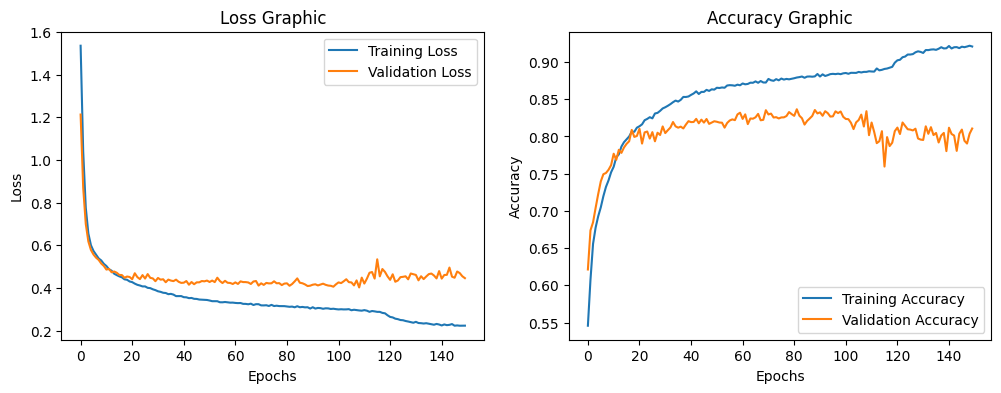

In [18]:
# Plotar o histórico do treinamento
plot_training_history(history)

140/140 [==============================] - 1s 8ms/step


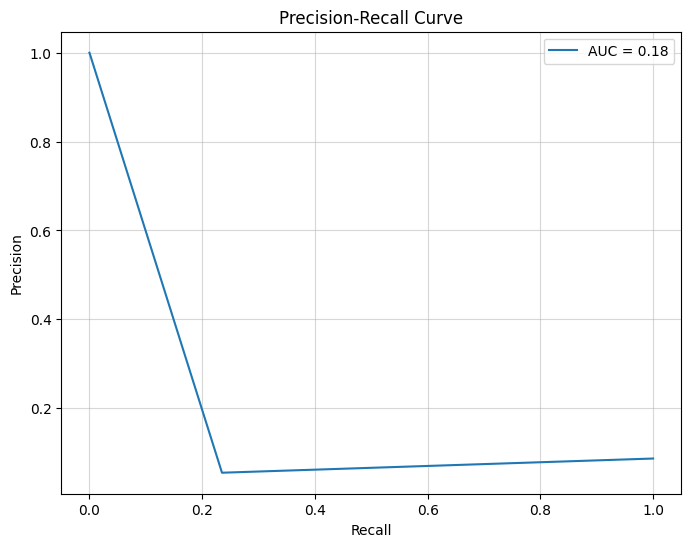

In [19]:
# Carregando pesos da melhor época
siamese_model.load_weights('best_model.h5')

# Avaliar o modelo na validação
y_pred_valid = (siamese_model.predict([valid_left_balanced, valid_right_balanced]) > 0.5)

# Avaliar o modelo no teste
y_pred_test = (siamese_model.predict([test_left, test_right]) > 0.5)

# Calcula a curva precision-recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_test)

# Calcula a AUC precision-recall
auc_pr = auc(recall, precision)

# Plote a curva precision-recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(alpha=0.5)
plt.show()

In [20]:
# Gerar o relatório de classificação
print("Validação:")
print(classification_report(y_valid_balanced, y_pred_valid))
print("\n#########################################################\n")
print("Teste:")
#print(classification_report(y_test, y_pred_test)) 
print(classification_report(y_test, y_pred_test)) 

Validação:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      8749
           1       0.87      0.79      0.83      8749

    accuracy                           0.83     17498
   macro avg       0.84      0.83      0.83     17498
weighted avg       0.84      0.83      0.83     17498


#########################################################

Teste:
              precision    recall  f1-score   support

           0       0.89      0.61      0.73      4091
           1       0.05      0.24      0.09       387

    accuracy                           0.58      4478
   macro avg       0.47      0.42      0.41      4478
weighted avg       0.82      0.58      0.67      4478



Validação:


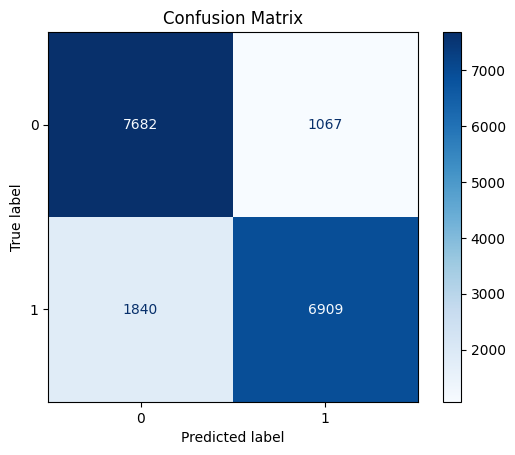


#########################################################

Teste:


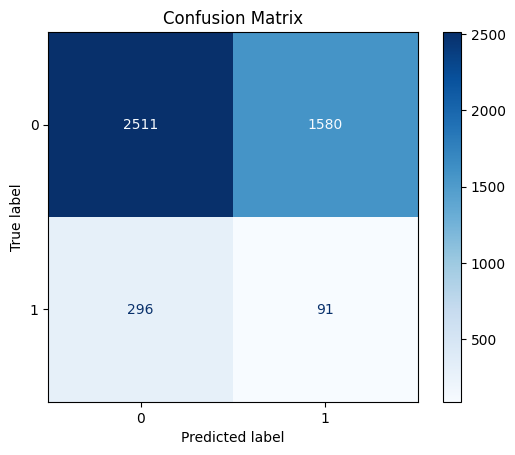

In [21]:
# Gerar a matriz de confusão
print("Validação:")
plot_confusion_matrix(y_valid_balanced, y_pred_valid)
print("\n#########################################################\n")
print("Teste:")
#plot_confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(y_test, y_pred_test)

In [22]:
# Função para adicionar borda ao patch com a cor da classificação
def add_border(image, color, thickness=3):
    image_normalized = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image_rgb = cv2.cvtColor(image_normalized, cv2.COLOR_GRAY2RGB)
    bordered_image = cv2.copyMakeBorder(image_rgb, thickness, thickness, thickness, thickness, cv2.BORDER_CONSTANT, value=color)
    return bordered_image

# Função para carregar imagens no formato NIfTI (.nii.gz)
def load_nii_slice(patient_id, slice_index, base_path):
    file_path = os.path.join(base_path, patient_id, f"Slice_{slice_index:03d}.nii.gz")
    if os.path.exists(file_path):
        nii_img = nib.load(file_path)
        img_data = nii_img.get_fdata()
        return img_data
    return None

# Função para carregar coordenadas de arquivos .txt
def load_coordinates(patient_id, slice_index, base_path):
    coord_file = os.path.join(base_path, patient_id, f"Slice_{slice_index:03d}.txt")
    if os.path.exists(coord_file):
        with open(coord_file, "r") as file:
            coordinates = [tuple(map(int, line.strip().split(","))) for line in file]
        return coordinates
    return []

# Função para sincronizar as classificações entre os lados do cérebro
def synchronize_classifications(coordinates, classifications, img_width):
    left_side = []
    right_side = []
    
    # Separar patches em lado esquerdo e direito com base em x1, x2
    for i, (y1, y2, x1, x2) in enumerate(coordinates):
        if x2 <= img_width // 2:  # Patches no lado esquerdo
            left_side.append((i, (y1, y2, x1, x2)))
        else:  # Patches no lado direito
            right_side.append((i, (y1, y2, x1, x2)))
    
    # Sincronizar classificações entre os dois lados
    for left, right in zip(left_side, right_side):
        left_idx, left_patch = left
        right_idx, right_patch = right
        
        # Igualar a classificação do lado direito com o lado esquerdo
        classifications[left_idx] = classifications[right_idx]
    
    return classifications

# Função para reconstruir a imagem e sobrepor o grid
def build_image_with_grid(patient_id, slice_index, labels_pred, labels_true, image_path, mask_path, coordinates_path):
    img = load_nii_slice(patient_id, slice_index, image_path)
    mask = load_nii_slice(patient_id, slice_index, mask_path)
    coordinates = load_coordinates(patient_id, slice_index, coordinates_path)
    
    if img is None or mask is None or not coordinates:
        return None, None
    
    reconstructed_img = np.zeros((233, 197, 3), dtype=np.uint8)
    reconstructed_mask = np.zeros((233, 197, 3), dtype=np.uint8)
    
    colors = {"TP": (0, 255, 0), "TN": (0, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}
    classifications = []

    # Determinar a classificação de cada patch
    for i, (y1, y2, x1, x2) in enumerate(coordinates):
        if labels_pred[i] == 1:
            if labels_true[i] == 1:
                if (calculate_label(mask[:, :(mask.shape[1] // 2)]) or calculate_label(mask[:, (mask.shape[1] // 2):])):
                    classification = "TP"
                else:
                    classification = "FP"
            else:
                classification = "FP"
        elif labels_pred[i] == 0:
            if labels_true[i] == 1:
                classification = "FN"
            else:
                if (calculate_label(mask[:, :(mask.shape[1] // 2)]) or calculate_label(mask[:, (mask.shape[1] // 2):])):
                    classification = "FN"
                else:
                    classification = "TN"
        classifications.append(classification)
    
    # Sincronizar classificações entre os lados do cérebro
    classifications = synchronize_classifications(coordinates, classifications, 197)
    
    # Reconstruir a imagem com base nas classificações sincronizadas
    for i, (y1, y2, x1, x2) in enumerate(coordinates):
        classification = classifications[i]
        
        patch_img = img[y1+3:y2-3, x1+3:x2-3]
        patch_mask = mask[y1+3:y2-3, x1+3:x2-3]
        bordered_patch_img = add_border(patch_img, colors[classification])
        bordered_patch_mask = add_border(patch_mask, colors[classification])
        
        # Inserir os patches na imagem reconstruída
        reconstructed_img[y1:y2, x1:x2] = bordered_patch_img
        reconstructed_mask[y1:y2, x1:x2] = bordered_patch_mask
    
    return reconstructed_img, reconstructed_mask


In [23]:
# Função para gerar PDF
def plot_patient_slices(pdf_filename, patients, coordinates_path, image_path, mask_path, labels_true, labels_pred):
    os.makedirs(os.path.dirname(pdf_filename), exist_ok=True)
    
    with PdfPages(pdf_filename) as pdf:
        for patient in patients:
            for slice_index in range(test_patients_quantity[patient]):
                img_recon, mask_recon = build_image_with_grid(patient, slice_index, labels_pred, labels_true, image_path, mask_path, coordinates_path)
                
                if img_recon is None:
                    continue
                
                fig, axs = plt.subplots(2, 1, figsize=(6, 6))
                axs[0].imshow(img_recon, cmap='gray')
                axs[0].set_title(f'Paciente {patient} - Imagem')
                axs[0].axis('off')
                axs[1].imshow(mask_recon, cmap='gray')
                axs[1].set_title(f'Paciente {patient} - Máscara')
                axs[1].axis('off')
                
                pdf.savefig(fig)
                plt.close(fig)
                
        print(f"As imagens foram salvas no arquivo PDF {pdf_filename} com sucesso.")

# Chamando a função para gerar o PDF
test_patients_quantity = {'sub-03C08': 1013, 'sub-51C05': 1254, 'sub-52K04': 1147, 'sub-59E09': 1064}
plot_patient_slices(
    pdf_filename="Pdf_SNN/Pacientes_Test_Reconstruidos_Com_Uppersampling.pdf",
    patients=test_patients,
    coordinates_path="Coordenadas_grid",
    image_path="Fatias",
    mask_path="Mask_Fatias",
    labels_true=y_test,
    labels_pred=y_pred_test
)

As imagens foram salvas no arquivo PDF Pdf_SNN/Pacientes_Test_Reconstruidos_Com_Uppersampling.pdf com sucesso.
